# Clustering Toronto Neighbourhoods
#### Part 1: Data preperation

This notebook extracts Neighbourhood information from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and combines it with geographical coordinates, obtained from [cocl.us](https://cocl.us/Geospatial_data). Neighbourhoods from Downtown, North, East and Central Toronto are visualised using Folium and saved to csv for further analysis.

### Load Libraries

In [1]:
## Built in libraries
import requests # HTTP requests

# Third party libraries
import numpy as np # arrays 
import pandas as pd # Data structures

import folium # Visualising interactive maps

import matplotlib.pyplot as plt # Plotting simple maps
import matplotlib.cm as cm # Colourmaps
import matplotlib.colors as colors # converting colours to RGB
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler # Min Max Scaling for features

from sklearn.cluster import KMeans # KMeans clustering model

from sklearn.metrics import silhouette_score # silhouette score used for helping determine K 
from yellowbrick.cluster import SilhouetteVisualizer # Creating Silhouette plots


## Load data

Here we load the dataframe, tor_boro.csv, which we saved previously in the Toronto_data_prep notebook. This csv is a list of all post codes in the Boroughs of Downtown, North, East and Central Toronto, with neighbourhood names and geographical coordinates. 

In [2]:
tor_boro = pd.read_csv('tor_boro.csv')

## Define functions and objects

#### Initilise cat_list

cat_list is a list of all categories and their subsequent child directories available on the FourSquare API.

It is initialised here to avoid calling the API unnecessarily.

This cell also includes foursquare API credentials which are required for calls using getNearbyVenues.


In [3]:
CLIENT_ID = 'JHD12LNKPLUI4FCOPN1Q0QAZS2CCIYWXXXYHUBOOYPD3LBRR' # Foursquare ID
CLIENT_SECRET = 'L1TC5ELHY2RAETCJOCMOF3OFA4KHWLXIHOJDFYNU0NNG14KS' # Foursquare Secret
VERSION = '20190425' # Foursquare API version

# Create categories endpoint URL
url = 'https://api.foursquare.com/v2/venues/categories??&client_id={}&client_secret={} \
        &v={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET,
        VERSION)

# Create lists of venue categories from Foursquare endpoint URL 
cat_list = requests.get(url).json()['response']['categories']

### Define _getParentCat

getParentCat is a function which returns the parent category of a venues category when found using the Foursquare app. The Foursquare Venue Category Hierarchy can be found in the Foursquare [docs](https://developer.foursquare.com/docs/build-with-foursquare/categories/).

Note that cat_list must be defined as intended for getNearbyVenueCats to work. As mentioned above, cat_list is not defined within the function to avoid unnecessarily calling the API.

In [4]:
    def _getParentCat(cat_list: list, target_id: str) -> str:

        '''This function returns the parent category given a Foursquare 'venue category'

        Note that cat_list is a list of all Foursquare categories and their subsequent 
        child directories and must be defined prior to using this function.
        '''
    
        for element in cat_list:
            if element['name'] == target_id:
                return element['name']
            else:
                if element['categories']:
                    check_child = _getParentCat(element['categories'], target_id)
                    if check_child:
                        return element['name']


### Define getNearbyVenueCats

getNearbyVenues uses the Foursquare explore endpoint and getParentCat function to return lists of neighbourhoods' venues by category.

Names, latitudes and longitudes arguments must be passed in the form of iterables. Limit and radius arguments are optional and are 100 and 500 respectively by default.

More information on the Foursquare explore endpoint can be found in the [docs](https://developer.foursquare.com/docs/api-reference/venues/explore/).

In [5]:
def getNearbyVenueCats(names, latitudes, longitudes, limit = 100, radius = 1000):
    
    '''
    Uses the Foursquare explore endpoint and getParentCat function to return lists 
    of neighbourhoods' venues by category
    '''
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):        
       # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}\
        &v={}&ll={},{}&limit={}&radius={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            limit,
            radius
            )
         
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(name, _getParentCat(cat_list,
                            v['venue']['categories'][0]['name'])) for v in results])
        
        cat_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list],
                                columns = ['Neighbourhood','Venue_Category'])
        
        # Create frequency table of venue categories for each neighbourhood
        
        # Change category names to dummy vals
        cat_freq_dum = pd.get_dummies(cat_df.Venue_Category,prefix='',prefix_sep='')

        # Sum dummy values for each category by 
        cat_freq = pd.concat([cat_df.Neighbourhood,cat_freq_dum],
                               axis=1).groupby('Neighbourhood').sum().reset_index()
        
    return cat_freq

The above functions are used to get the dataframes we will use for analysis. They are saved to csv for further exploration. 

The arguments for the getNearbyVenueCats can also be modified below. It has been run for radii of 500, 1000 and 2000 metres, for comparison.

In [6]:
names = tor_boro.Neighbourhood
lats = tor_boro.Latitude
lngs = tor_boro.Longitude
# limit = 100
radius = 500

toronto_venues_500 = getNearbyVenueCats(names, lats, lngs, radius=radius)

toronto_venues_500.to_csv('toronto_venues_500.csv',index=False)

In [7]:
names = tor_boro.Neighbourhood
lats = tor_boro.Latitude
lngs = tor_boro.Longitude
# limit = 100
radius = 1000

toronto_venues_1000 = getNearbyVenueCats(names, lats, lngs,radius=radius)

toronto_venues_1000.to_csv('toronto_venues_1000.csv',index=False)

In [8]:
names = tor_boro.Neighbourhood
lats = tor_boro.Latitude
lngs = tor_boro.Longitude
# limit = 100
radius = 2000

toronto_venues_2000 = getNearbyVenueCats(names, lats, lngs,radius=radius)

toronto_venues_2000.to_csv('toronto_venues_2000.csv',index=False)

## Load Datasets

Here, the geographical information created in part 1 and the venue categories information created in part 2 are loaded.

In [9]:
# Toronto Neighbourhoods geographical information
tor_boro = pd.read_csv('tor_boro.csv')  

# Count of venue catgeories within 500, 1000 and 2000m radius of Toronto Neighbourhoods
# Strored in a dict for ease of use
R = [500, 1000, 2000]
toronto_venues = {r:pd.read_csv('toronto_venues_'+str(r)+'.csv') for r in R}

## Analysing Neighbourhoods

Now that we have the 39 Toronto neighbourhoods with a count of nearby venues, grouped by category, we can proceed to cluster the Neighbourhoods.

First we scale the venue category counts.

In [10]:
scaled_features = {r:MinMaxScaler().fit_transform(toronto_venues[r][list(toronto_venues[r].columns.values)[1:]]) for r in R}

## Silhouette Coefficients

The higher the value of the silhouette coefficient or score, the better each data points 'fits' to its cluster and 'does not fit' to the other clusters (i.e. similarity within cluster/against dissimilarity to other clusters).

The sillhoutte coefficient calclulated below is the mean of the silhouette coefficient or score of each data point. Therefore, these plots are a type of 'goodness of fit test' of the overall kmeans model. 

Sillhoutte coefficients take values between -1 and 1. For an data point with a score of 1, it would indicate optimal clustering. A value of 0 indicates that observation lies exactly between clusters, while a negative values indicates it is likely in the wrong cluster. 

For more information see the sci-kit learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

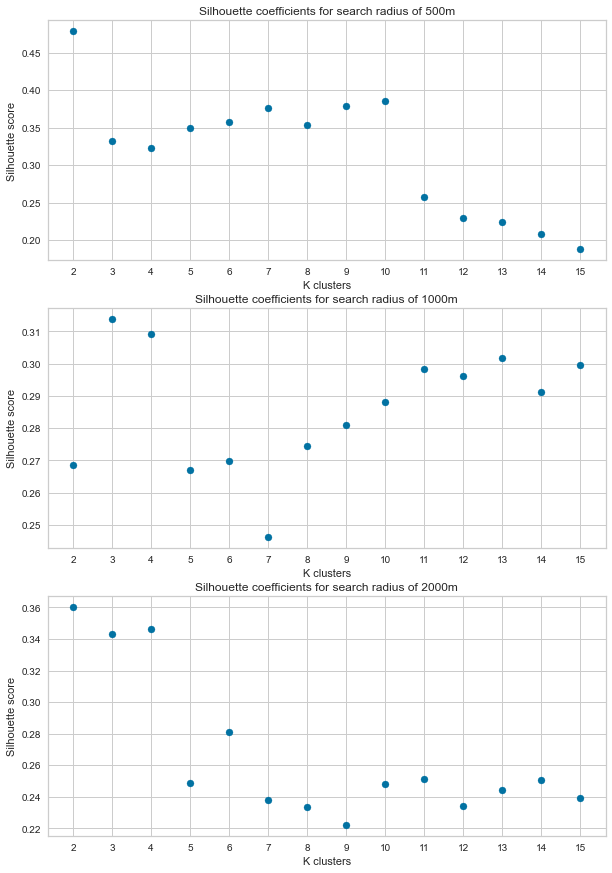

In [11]:
# The range of k values tested for
K = range(2,16)

# Create a list of K-Means cluster algorithms for the scaled vlaues over the range of ks
kmeans = {r:[KMeans(n_clusters=k, random_state=0).fit(scaled_features[r]) for k in K] for r in R}

# Create a list of silhoutte scores for the K-Means cluster algorithms over the range of ks
sil = {r:[silhouette_score(scaled_features[r], model.predict(scaled_features[r]))
          for model in kmeans[r]] for r in R}

plt.rcParams["figure.figsize"] = (10,15)

ax1 = plt.subplot(311)
ax1.set_title('Silhouette coefficients for search radius of 500m')
ax1.scatter(K,sil[500])

ax2 = plt.subplot(312)
ax2.set_title('Silhouette coefficients for search radius of 1000m')
ax2.scatter(K,sil[1000])

ax3 = plt.subplot(313)
ax3.set_title('Silhouette coefficients for search radius of 2000m')
ax3.scatter(K,sil[2000])

for ax in (ax1,ax2,ax3):
    ax.set(xlabel='K clusters', ylabel='Silhouette score',xticks=K)
    ax.grid(which='minor')

From the above plots we can see the closeness of fit for the three search radius for a range of 2 to 15 clusters. 

As noted above, the higher the value of K, the better the data points fit the clusters. 

For 500 metres a 2 cluster solution has the best fit. In fact, this is the best fit of all of the models. We also note that for this search radius, we have relatively high silhouette coefficients for values of K up to 10. The high coefficients for this search radius are possibly due to the Neighbourhoods being less likely to overalap search areas and share venues, therefore being more diverse and easy to cluster. 

For 1000 metres, 3 to 5 clusters appears to be optimal. However, we do note that these values are quite low compared to other radii.  

In the 2000m plot we see again the 2 clusters yields the highest coefficient score. 3 and 4 cluster solutions also appear to be relatively strong, with a sharp drop off after this point.

As the silhouette coefficient of the model is simply the mean of the silhouette coefficients of all the individual data points, it may be skewed based on some extremely well or poorly fitted data points.

We may have a high silhouette coefficient for a model as a result of a majority certain clusters or data points fitting really well together, while some clusters or data points fit really poorly. 

Silhouette plots can be used to visualise the silhouette coefficients of all individual data points, as well as the cluster sizes.

Ideally, we want clusters of similar sizes, with the majority of data points fitting consitently well. 

Below we have produced Silhouette plots of some relvant values of K for our search radii. The plots have also been saved as .png files. 

## Silhouette Plots

### 500m search radius

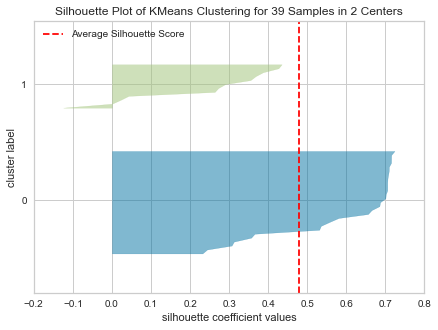

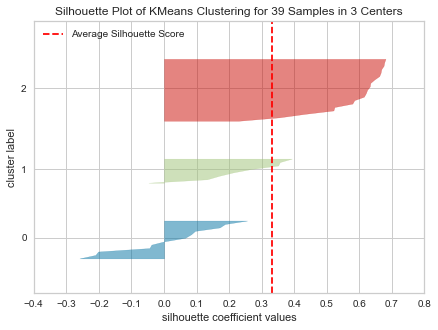

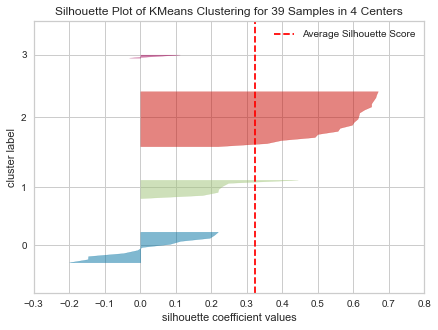

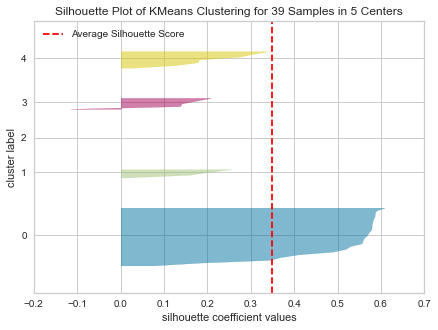

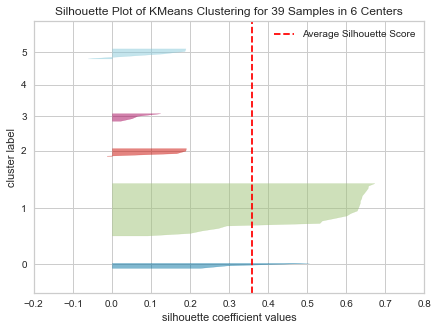

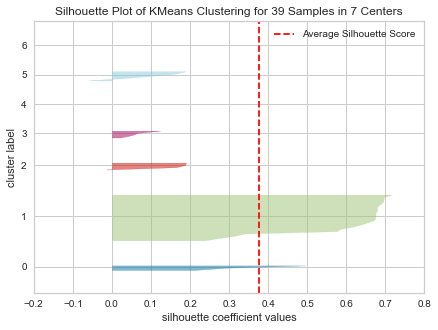

In [12]:
K = range(2,8)

plt.rcParams["figure.figsize"] = (7,5)

for k in K:
    fig = plt.figure()
    visualizers = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=0), colors='yellowbrick')
    visualizers.fit(scaled_features[500])
    visualizers.show(outpath="silhouette_plots/500m/silhouette_plot_R=500m_&_K="+str(k)+".png")

### 1000m search radius

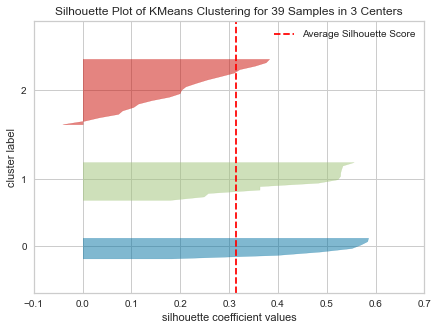

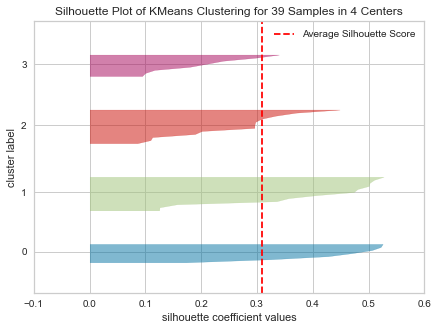

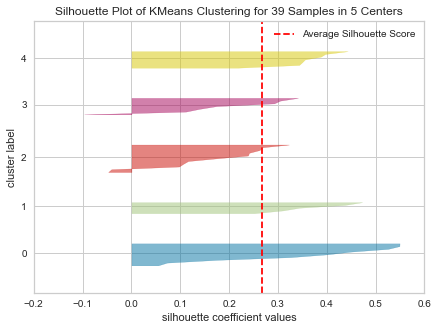

In [13]:
K = range(3,6)

plt.rcParams["figure.figsize"] = (7,5)

for k in K:
    fig = plt.figure()
    visualizers = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=0), colors='yellowbrick')
    visualizers.fit(scaled_features[1000])
    visualizers.show(outpath="silhouette_plots/1000m/silhouette_plot_R=1000m_&_K="+str(k)+".png")

### 2000m search radius

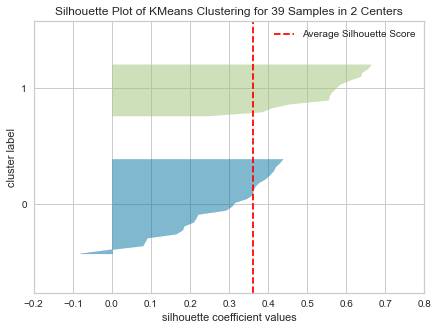

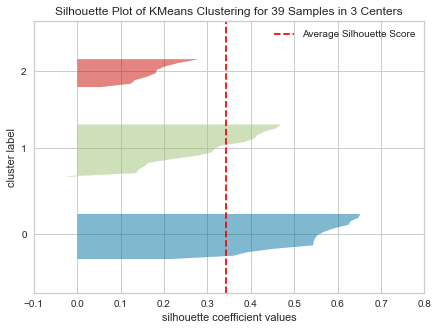

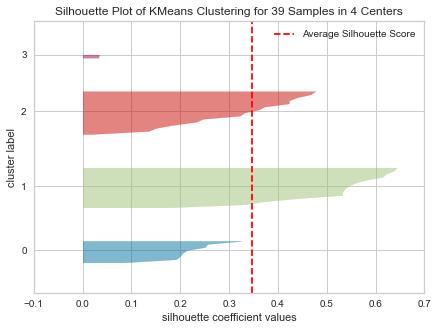

In [14]:
K = range(2,5)

plt.rcParams["figure.figsize"] = (7,5)

for k in K:
    fig = plt.figure()
    visualizers = SilhouetteVisualizer(KMeans(n_clusters=k, random_state=0), colors='yellowbrick')
    visualizers.fit(scaled_features[2000])
    visualizers.show(outpath="silhouette_plots/2000m/silhouette_plot_R=2000m_&_K="+str(k)+".png")

## Conclusion



The Silhouette plots for the 500 metre search radius did not yield particularly encouraging results. We notice the high mean value is a result of the similarity of a large section of these data points. This cluster is represented by the thickest and longest spike, which can be seen and remains significant in nearly all of the 500 metre plots. Further investigation of this shows that this is a result of the outer Toronto having very few search results. This can be seen in the Mapping Clusters and conclusion section.

Despite the coefficient bias to the outer cluster, we note that for this radius 2 clusters still appears to be the most optimal solution. We should also note that from 5 clusters and above, outlier clusters and small clusters of 2 or 3 neighbourhoods begin to become common, meaning these solutions possibly aren't ideal either. 

Given a 1000 metre search radius the data appears to be dispersed somewhat better as we have yielded clusters of more consistant sizes and 'goodness of fit' values. However, there are still some data points which show very little correlation to their clusters and the overall coefficient mean is far from ideal. The 4 cluster solution seems like the best fit with no real outliers and good evenly dispersed clusters.

The silhouette plots for the 2000 metre search radius confirm that increasing the number of clusters above 2 only results in less well fitting clusters, as suggested by the mean silhouette coefficient values. Similar to the 500m radius clusters, this radius appears to benifit from an increased coeffiecient mean due to the similarity of one set of data points. Further inspections of these points shows that these are the inner Neighbourhoods (see the map in part 4). This is predictable as many of these neighbourhoods are within the search radius of each other and will likely share nearby venues in the result set.

## Part 4: Clustering and visualising the neighbourhoods

This notebook clusters toronto neighbourhoods based on the similarity of nearby venue categorys and visualises them using folium.

## Define function

mapClusters is used for visualisation of clustered neighbourhoods, produced with folium.

In [15]:
def mapClusters(k: int,r: int) -> folium.Map: 
    '''
    This function uses folium to map clustered neighbourhoods, which are distinguished
    by colour.
    
    Before running this function, kmeans clustering must be run on the toronto
    venues (scaled) data, which is obtained from the getNearbyVenueCats function.
    
    The input k refers to the number of clusters which was used, while n is the
    radius used in the getNearbyVenueCats function.   
    '''
    
    toronto_clusters = pd.DataFrame(toronto_venues[r].Neighbourhood).merge(
        tor_boro[['Neighbourhood', 'Latitude', 'Longitude']])

    #Get central coordinates for Toronto map
    latitude = tor_boro.Latitude.mean()
    longitude = tor_boro.Longitude.mean()

    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_features[r])
    
    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(toronto_clusters['Latitude'], toronto_clusters['Longitude'],
                                      toronto_clusters['Neighbourhood'], kmeans.labels_):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

## Analysing Neighbourhoods

Now that we have the 39 Toronto neighbourhoods with a count of nearby venues, grouped by category, we can proceed to cluster the Neighbourhoods.

First we scale the venue category counts.

In [16]:
scaled_features = {r:MinMaxScaler().fit_transform(toronto_venues[r][list(toronto_venues[r].columns.values)[1:]]) for r in R}

## K-Means Clustering

K-Means clustering will be used to cluster neighbourhoods based on the similarity of the number of venue categories nearby.

Silhouette coefficients for K-means models given various values of K, as well as their respective silhouette plots, were used to determine which combinations of radii and clusters should be investigated further. This can be seen in part 3 of the project.

The k means models are created and fitted to the scaled data in the mapClusters function.

## Mapping clusters

The mapClusters function was used to produce maps of the Toronto neighbourhoods given a specified number of clusters and search radius.

#### 500m, 2 cluster map

In [17]:
# set number of clusters and radius
k = 2
r = 500

mapClusters(k,r)

#### 2000m, 2 cluster map

In [18]:
# set number of clusters and radius
k = 2
r = 2000

mapClusters(k,r)

#### 1000m, 4 cluster map

In [20]:
# set number of clusters and radius
k = 4
r = 1000

mapClusters(k,r)

## Observations

#### 2 Clusters

As seen in part 3, the 500m radius and 2 cluster solution had the highest mean silhouette score, which indicates the best closeness of fit. 

Similarly, for 2000m, the 2 cluster solution had the highest silhouette coefficient for that search radius.

Although, these results do have relatively well defined clusters, a 2 cluster solution does not really give us much useful insight. As can be seen in the visualisations, with 2 clusters, we see that neighbourhoods are simply split between those close to the centre and those further out. It is quite intuiative that neighbouroods nearer to a city centre will have more venues nearby than a neighbourhood further away from the centre, and perhaps using kmeans clustering to confirm this is a little superfluous.

In fact, the only difference between the 500 and 2000m clusters is that the centre cluster has a larger radius for the larger search radius case, again, as we would expect. 

We should however note that these clusters aren't completely geographically spherical. This proves that, even close to the city centre, some neighbourhoods have a higher density of venues than others and that this density of venues doesn't decline exactly evenly proportionally as the distance increases.

#### 4 Clusters

The 1000m 4 cluster solution has produced a somewhat less predictable output. The outer neighbourhoods have been split somewhat randomly while the central neighbourhoods appear to have been split into a group nearer to the university and a group nearer to the train station.

We should note however that this has the lowest silhouette score of those shown above meaning that these clusters are possibly not as optimal as some of the other solutions. If we were to investigate some of the data points within these clusters we would in fact find that some neighbourhoods within clusters are not particularly similar. Checking the silhouette plot from part 3, this is particulary evident with clusters 2 and 3.


## Conclusions

While we have gained some insights into what types of venues are nearby to the neighbourhoods around Toronto, it is worth noting that there are some limitations to this method and the solutions obtained.

Firstly, the data is not organised very clustered manner. The mean silhouette scores are not particularly high while the silhouette plots showed that it was hard to evenly group neighbourhoods in similarly sized and distanced (in the feature space) clusters.  

One issue with the dataset may be the 100 result limit forced by Foursquare. It is highly likely that most of the inner Toronto neighbourhoods had many venues missing, potentially skewing results.

Another issue that could be addressed in future test would be feature selection. The prescence of a very small number of 'College & University', 'Professional & Other Places' and 'Residence' venues in very few neighbourhoods, made it very hard to properly cluster these neighbourhoods. Removing these categories it was found that the mean silhouette score increased in most cases and could even be increased beyond 0.50.

Including more feature, such as crime rate, public transport accessabilty, average purchase/renatal cost, nearby schools and so on, may also discover more similarities and disimilarites that could be useful for accurate clustering.